# Exploratory Data Analysis & Intro

## Goal
1.  Investigate top-paying roles and skills in the data science industry.
2.  Use Python to explore a real-live dataset on job postings.
3.  For job-seekers: use these insights to help find the best job opportunities.

## Final Deliverables:
* Create Jupyter Notebooks (showcasing core skills in Python).
* Create a summary page (via `README.md`) capturing your findings.
* Share this project with GitHub & LinkedIn.

# Questions to Answer

1. **Volatility in Daily Cases** – Measure which country had the highest variability in daily new cases.

2. **Peak Timing** – Determine when the top 5 countries by total cases reached their peak of daily new cases and how long it took from their first case.

3. **Outlier Detection** – Detect countries that were outliers in death-to-case ratio compared to the global average.

4. **Recovery vs. Mortality** – Explore the relationship between recovery rates and death rates for the top 10 countries.

5. **Case Fatality Dynamics** – Track how the case fatality rate evolved over time for the top 3 countries.

6. **Growth Analysis** – Identify which countries had the fastest growth in confirmed cases during the first 30 days after their first reported case.

7. **Comparing First Waves** – Compare how quickly different countries moved from 100 to 10,000 confirmed cases.

8. **Lag Analysis** – Investigate the average time lag between the peaks of confirmed cases and deaths across countries.

9. **Time to Plateau** – Find out which countries flattened the curve earliest based on moving averages of new cases.

10. **Continental Trends** – Analyze which continent drove the second wave of the pandemic and compare it with the first wave.



In [35]:
import ast 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/covid_19_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

#clean
df['ObservationDate']= pd.to_datetime(df['ObservationDate'])

df.columns = df.columns.str.replace(' ', '_')
df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='mixed') 
# df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='%m/%d/%y %H:%M', errors='coerce')
# we can also use that format but we cant bec our data include more than one time format for instance (1/22/2020 17:00, 2021-05-30)
# so mixed sayes that me have more than one format

df.set_index('SNo', inplace=True)

df['Country/Region']= df['Country/Region'].fillna('else')
df['Province/State']= df['Province/State'].fillna('else')

df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].clip(lower=0) # replace -ve values with 0

### Cleaning and Some info about our data we are going to work with

In [36]:
pd.set_option('display.max_columns', None)

In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 306429 entries, 1 to 306429
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ObservationDate  306429 non-null  datetime64[ns]
 1   Province/State   306429 non-null  object        
 2   Country/Region   306429 non-null  object        
 3   Last_Update      306429 non-null  datetime64[ns]
 4   Confirmed        306429 non-null  float64       
 5   Deaths           306429 non-null  float64       
 6   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 18.7+ MB


In [38]:
df.describe()

,ObservationDate,Last_Update,Confirmed,Deaths,Recovered
count,306429,306429,3.064290e+05,306429.000000,3.064290e+05
mean,2020-11-06 01:54:54.146441728,2021-03-11 01:14:17.227314944,8.567190e+04,2036.404351,5.042314e+04
min,2020-01-22 00:00:00,2020-01-22 17:00:00,0.000000e+00,0.000000,0.000000e+00
25%,2020-07-30 00:00:00,2021-04-02 15:13:53,1.042000e+03,13.000000,1.100000e+01
50%,2020-11-10 00:00:00,2021-04-02 15:13:53,1.037500e+04,192.000000,1.751000e+03
75%,2021-02-18 00:00:00,2021-04-02 15:13:53,5.075200e+04,1322.000000,2.027000e+04
max,2021-05-29 00:00:00,2021-05-30 04:20:55,5.863138e+06,112385.000000,6.399531e+06
std,NaN,NaN,2.775508e+05,6410.937689,2.015058e+05


In [39]:
# check of there is -ve values
df[(df['Deaths'] < 0) | (df['Recovered'] < 0) | (df['Confirmed']< 0)]


,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,


### note: clip(lower=0)

Parameters:

lower → minimum allowed value. Anything smaller is replaced.

upper → maximum allowed value. Anything bigger is replaced.

axis → usually not needed. Defines along which axis clipping is applied (rows or columns).

inplace → if True, modifies the DataFrame directly without creating a copy.

🔹 Examples
1. Basic Usage (Series)
```python
import pandas as pd
s = pd.Series([-5, 0, 5, 10, 15])

s.clip(lower=0, upper=10)
```
---

```python
Output:

0     0
1     0
2     5
3    10
4    10
dtype: int64
```


In [40]:
# replace -ve values with 0
df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].clip(lower=0)

In [41]:
# check -ve values
df[(df['Deaths'] < 0) | (df['Recovered'] < 0) | (df['Confirmed']< 0)]

,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,


## **Global Overview**

In [42]:
# ❌❌ wrong because we here adding comulative to each other  
#df_OD_2021= df[df['ObservationDate'].dt.year == 2021] # take only the data after 2021
#country_totals = df_OD_2021.groupby('Country/Region')['Confirmed'].sum().sort_values(ascending=False)
#country_totals

In [43]:
# Find the latest date (2021-05-29)
latest_date = df['ObservationDate'].max() 

# Filter data for that date
df_latest = df[df['ObservationDate'] == latest_date]

# Sum confirmed cases across provinces for each country
country_totals = df_latest.groupby(['Country/Region', 'ObservationDate'])['Confirmed'].sum()

# Get top 5 countries
df_top_5 = country_totals.sort_values(ascending=False).head()

# to df again

df_plot= df_top_5.reset_index()
df_plot


,Country/Region,ObservationDate,Confirmed
0,US,2021-05-29,33251939.0
1,India,2021-05-29,27894800.0
2,Brazil,2021-05-29,16471600.0
3,France,2021-05-29,5719877.0
4,Turkey,2021-05-29,5235978.0


C:\Users\go\AppData\Local\Temp\ipykernel_13876\2548379040.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  df_sns= sns.barplot(data=df_plot, x='Confirmed', y='Country/Region', palette='mako')


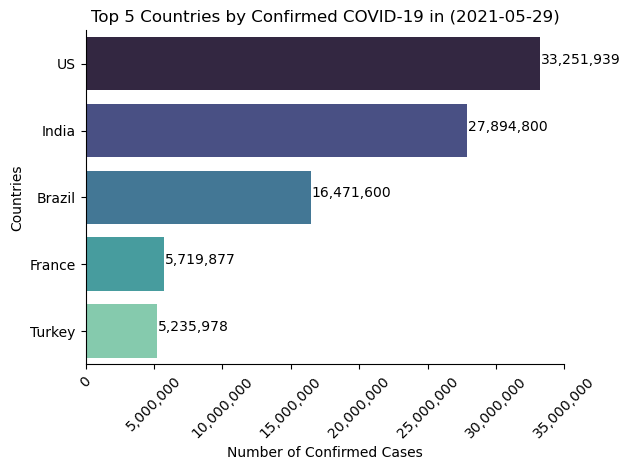

In [44]:
df_sns= sns.barplot(data=df_plot, x='Confirmed', y='Country/Region', palette='mako')

for index, value in enumerate(df_plot['Confirmed']):
    plt.text(value +50000, index, f'{int(value):,}')

plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
df_sns.set_xlabel('Number of Confirmed Cases')
df_sns.set_ylabel('Countries')
plt.title('Top 5 Countries by Confirmed COVID-19 in (2021-05-29)')
plt.xticks(rotation=45)
df_sns.set_xlim(0, 35000000)

sns.despine()
plt.tight_layout()
plt.show()


### note about: df.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

> “If each country’s data is already cumulative, and I do `.sum()`, what stops Python from summing everything — like adding the totals from every day together — instead of just the totals *for that day* across countries?”

That’s **exactly** what the `groupby('ObservationDate')` part controls.

---

## 🧩 Step-by-step explanation

Let’s start from the logic of your code:

```python
global_daily = df.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
```

### 1️⃣ `df.groupby('ObservationDate')`

This tells Python:

> “Group all rows that have the same date into one bucket.”

So for example:

* All rows with `ObservationDate = 2020-03-15` go into one group.
* All rows with `ObservationDate = 2020-03-16` go into another group.
* And so on.

➡️ This ensures that **Python never mixes data between different dates**.

---

### 2️⃣ `[["Confirmed", "Deaths", "Recovered"]]`

This selects only the numerical columns we care about.

---

### 3️⃣ `.sum()`

Now, `.sum()` operates **within each group** (that’s the key point!).

So for each date (each group), it adds up the values of all countries that have data for that date.

It’s equivalent to saying:

> For each date, add up Confirmed + Deaths + Recovered **across all countries** that reported on that date.

It doesn’t sum across dates — it sums **within each date**.

---

### 4️⃣ `.reset_index()`

Finally, this step turns the grouped data back into a normal DataFrame (instead of a GroupBy object).

---

## 🧮 Simple example

Let’s take a small dataset:

| ObservationDate | Country | Confirmed |
| --------------- | ------- | --------- |
| 2020-01-01      | China   | 100       |
| 2020-01-01      | Italy   | 20        |
| 2020-01-02      | China   | 200       |
| 2020-01-02      | Italy   | 30        |

Now you run:

```python
df.groupby('ObservationDate')['Confirmed'].sum()
```

Here’s what Python does internally:

* For **2020-01-01** → sum of [100 (China) + 20 (Italy)] = **120**
* For **2020-01-02** → sum of [200 (China) + 30 (Italy)] = **230**

So the output is:

| ObservationDate | Confirmed |
| --------------- | --------- |
| 2020-01-01      | 120       |
| 2020-01-02      | 230       |

See?
Python sums per **date**, not across all rows of the dataset.

That’s why we say:

> `.groupby('ObservationDate').sum()` combines all **countries’ cumulative totals per day**, not across days.

---

### 🧩 Why it’s safe here

Because every country reports *its own* cumulative total each day, summing across countries gives you the **global cumulative total** for that day — no overcounting across time.

---

✅ **In short:**

> `groupby('ObservationDate')` tells Python *“sum within each day, not across days.”*
> That’s why it correctly combines per-country cumulative values into one **global cumulative total per day.**

In [45]:
#global_daily = df.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
#global_daily ❌❌ wrong because of duble counting

daily_country = df.groupby(['Country/Region', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()
global_daily = daily_country.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
global_daily

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,454.0,17.0,30.0
1,2020-01-23,459.0,17.0,30.0
2,2020-01-24,573.0,24.0,34.0
3,2020-01-25,798.0,40.0,35.0
4,2020-01-26,1111.0,52.0,49.0
...,...,...,...,...
489,2021-05-25,77299140.0,1638749.0,58195720.0
490,2021-05-26,77536096.0,1644180.0,58389676.0
491,2021-05-27,77787336.0,1649336.0,58629477.0
492,2021-05-28,78010562.0,1654601.0,58838698.0


## notice that

```python
ax.stackplot(
    global_daily['ObservationDate'],
    global_daily['Confirmed'],
    global_daily['Deaths'],
    global_daily['Recovered'],
    labels=['Confirmed', 'Deaths', 'Recovered'],
    colors=['#ff9999', '#9999ff', '#99ff99'],
    alpha=0.8
)
```

is the **core command** that creates your **stacked area chart** — a powerful way to visualize how multiple quantities (Confirmed, Deaths, Recovered) grow over time and contribute to a total.

Let’s break it down line by line 🔍

---

### 🧩 1️⃣ `ax.stackplot(x, y1, y2, y3, ...)`

* **`stackplot()`** stands for “stacked plot.”
* It takes:

  * One **x-axis array** (e.g. `ObservationDate`)
  * Multiple **y-axis arrays** (e.g. `Confirmed`, `Deaths`, `Recovered`)
* Then it **plots each y-value on top of the previous one**, creating a layered “stacked” visual.

💡 So on each date:

```
Total height = Confirmed + Deaths + Recovered
```

Each color band represents the contribution of one variable.

---

### 🧠 2️⃣ `global_daily['ObservationDate']`

* This is your **x-axis**.
* Each value is a date — e.g., 2020-01-22, 2020-01-23, etc.
* It shows how cases evolve over time.

---

### 🧠 3️⃣ `global_daily['Confirmed']`, `['Deaths']`, `['Recovered']`

* These are your **y-values** for each variable.
* They must be the same length as `ObservationDate`.
* Each represents the cumulative global count up to that date.

---

### 🎨 4️⃣ `labels=['Confirmed', 'Deaths', 'Recovered']`

* These labels are used in the **legend**, so you know which color corresponds to which variable.

---

### 🌈 5️⃣ `colors=['#ff9999', '#9999ff', '#99ff99']`

* These are the **fill colors** for each area layer:

  * `#ff9999` → light red for Confirmed
  * `#9999ff` → light blue for Deaths
  * `#99ff99` → light green for Recovered

---

### 💧 6️⃣ `alpha=0.8`

* This controls the **transparency** (opacity) of the color fills.
* `1.0` = fully opaque; `0.0` = fully transparent.
* `0.8` means 80% visible, so layers are distinguishable if they overlap slightly.

 


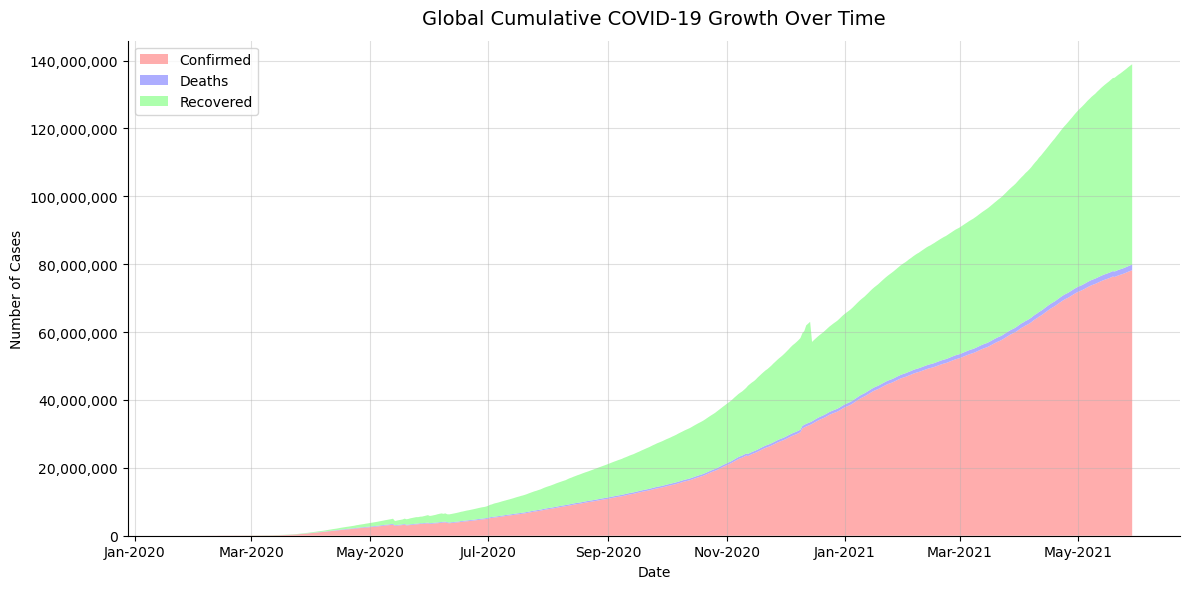

In [ ]:
plt.figure(figsize=(12, 6))
ax = plt.gca()  # Get the current Axes

ax.stackplot(
    global_daily['ObservationDate'],
    global_daily['Confirmed'],
    global_daily['Deaths'],
    global_daily['Recovered'],
    labels=['Confirmed', 'Deaths', 'Recovered'],
    colors=['#ff9999', '#9999ff', "#99ff99"],  
    alpha=0.8
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

sns.despine()

plt.title('Global Cumulative COVID-19 Growth Over Time', fontsize=14, pad=12)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(loc='upper left')
plt.grid(alpha=0.3) #Show a light grid with 30% opacity — just enough to guide the eye.

plt.tight_layout()
plt.show()
